# Evaluación de los modelos

En este cuaderno se evaluarán los modelos entrenados previamente (Decision Tree, Random Forest, Logistic Regression).  
El objetivo es comparar su rendimiento en el conjunto de test y seleccionar el más adecuado.

 

# Libs

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)


# Cargar

## Modelos

In [2]:
models_dir = os.path.join("..", "models")

with open(os.path.join(models_dir, "modelo_random_forest_optimizado.pkl"), "rb") as f:
    rf_model = pickle.load(f)

with open(os.path.join(models_dir, "modelo_decision_tree_optimizado.pkl"), "rb") as f:
    dt_model = pickle.load(f)

with open(os.path.join(models_dir, "modelo_logistic_regression.pkl"), "rb") as f:
    log_model = pickle.load(f)

modelos = {
    "Random Forest": rf_model,
    "Decision Tree": dt_model,
    "Logistic Regression": log_model
}


## Datos

In [3]:
test_dir = os.path.join("..", "data", "test")

# Para Logistic Regression (datos escalados)
X_test_std = pd.read_csv(os.path.join(test_dir, "X_test_log.csv"))
y_test_std = pd.read_csv(os.path.join(test_dir, "Y_test_log.csv"))

# Para árboles (Decision Tree y Random Forest)
X_test_tree = pd.read_csv(os.path.join(test_dir, "X_test.csv"))
y_test_tree = pd.read_csv(os.path.join(test_dir, "Y_test.csv"))

# Evaluación

In [4]:
resultados = []

for nombre, modelo in modelos.items():
    if nombre == "Logistic Regression":
        X_eval, y_eval = X_test_std, y_test_std
    else:
        X_eval, y_eval = X_test_tree, y_test_tree
    
    y_pred = modelo.predict(X_eval)
    y_proba = modelo.predict_proba(X_eval)[:,1] if hasattr(modelo, "predict_proba") else None
    
    reporte = classification_report(y_eval, y_pred, output_dict=True)
    auc = roc_auc_score(y_eval, y_proba) if y_proba is not None else np.nan
    
    resultados.append({
        "Modelo": nombre,
        "Precision (Clase 1)": reporte['1']['precision'],
        "Recall (Clase 1)": reporte['1']['recall'],
        "F1-score (Clase 1)": reporte['1']['f1-score'],
        "ROC-AUC": auc
    })

df_resultados = pd.DataFrame(resultados)
display(df_resultados)


C:\Users\joang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\joang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


,Modelo,Precision (Clase 1),Recall (Clase 1),F1-score (Clase 1),ROC-AUC
0,Random Forest,0.954082,0.944444,0.949239,0.986513
1,Decision Tree,0.924242,0.924242,0.924242,0.959916
2,Logistic Regression,0.880000,0.833333,0.856031,0.936897


##  Matrices de confusión

C:\Users\joang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


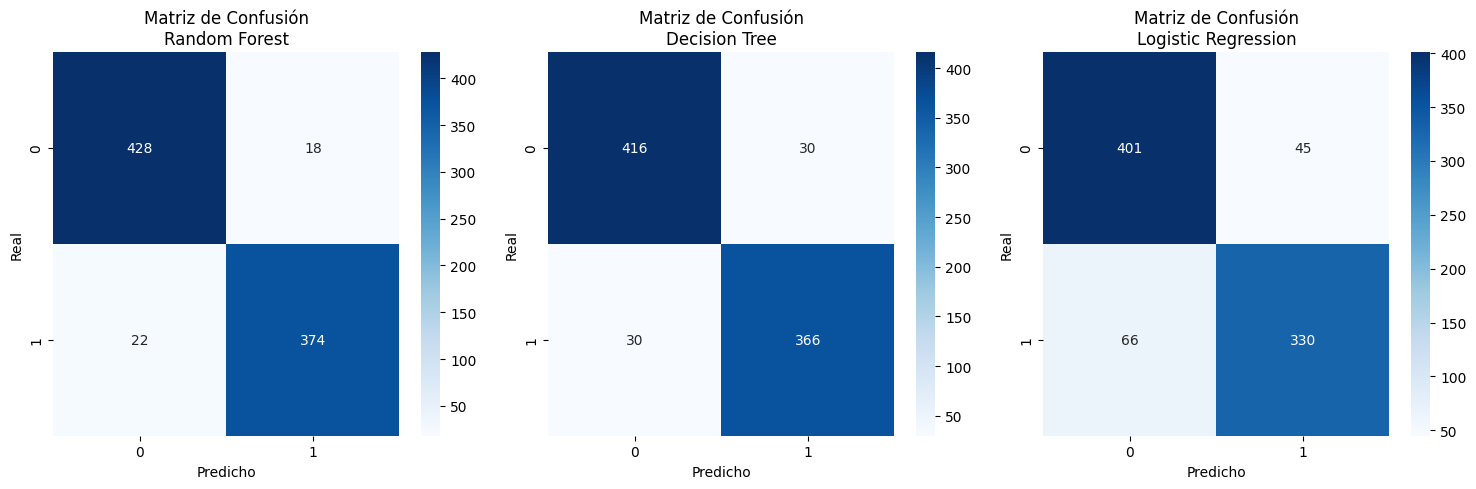

In [5]:
fig, axes = plt.subplots(1, len(modelos), figsize=(15,5))

for ax, (nombre, modelo) in zip(axes, modelos.items()):
    if nombre == "Logistic Regression":
        X_eval, y_eval = X_test_std, y_test_std
    else:
        X_eval, y_eval = X_test_tree, y_test_tree
    
    y_pred = modelo.predict(X_eval)
    cm = confusion_matrix(y_eval, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"Matriz de Confusión\n{nombre}")
    ax.set_xlabel("Predicho")
    ax.set_ylabel("Real")

plt.tight_layout()
plt.savefig("../reports/11-matrices_confusion_final.jpg", dpi=300, bbox_inches="tight")
plt.show()

## Curvas ROC

C:\Users\joang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


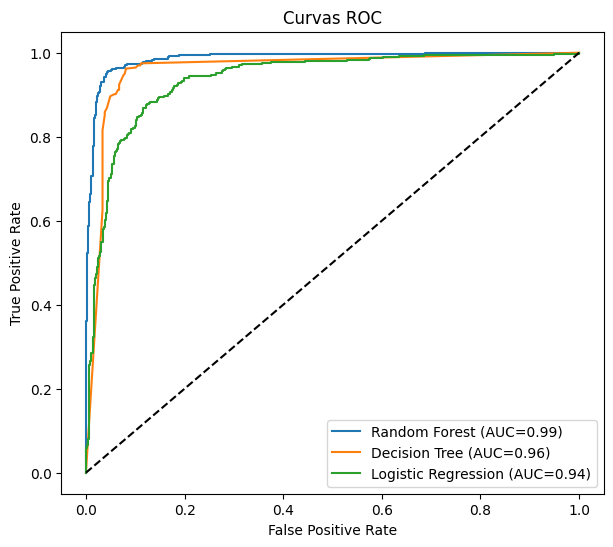

In [6]:
plt.figure(figsize=(7,6))

for nombre, modelo in modelos.items():
    if nombre == "Logistic Regression":
        X_eval, y_eval = X_test_std, y_test_std
    else:
        X_eval, y_eval = X_test_tree, y_test_tree
    
    if hasattr(modelo, "predict_proba"):
        y_proba = modelo.predict_proba(X_eval)[:,1]
        fpr, tpr, _ = roc_curve(y_eval, y_proba)
        auc = roc_auc_score(y_eval, y_proba)
        plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC")
plt.legend()
plt.savefig("../reports/12-curvas_ROC.jpg", dpi=300, bbox_inches="tight")
plt.show()

## Comparativa AUC y F1-score

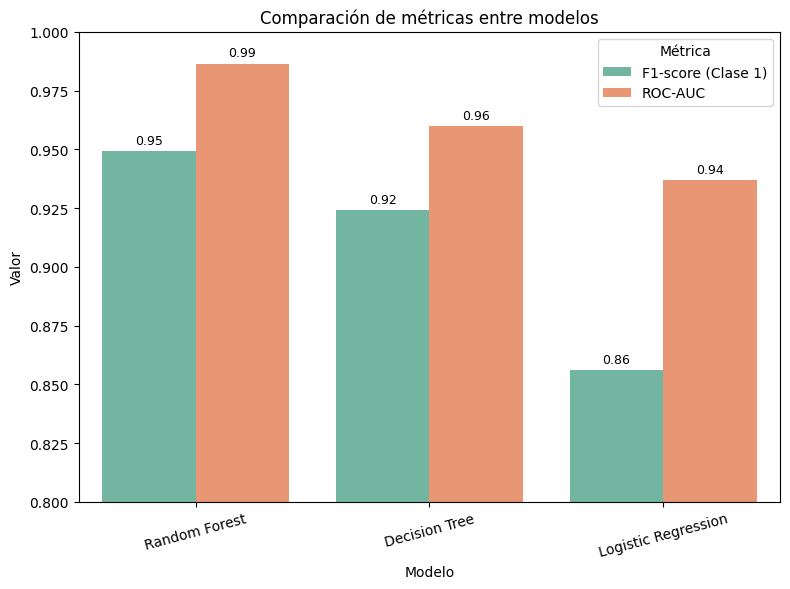

In [7]:
# Crear DataFrame con solo las métricas que queremos comparar
df_comparacion = df_resultados[["Modelo", "F1-score (Clase 1)", "ROC-AUC"]].melt(
    id_vars="Modelo",
    var_name="Métrica",
    value_name="Valor"
)

plt.figure(figsize=(8,6))
ax = sns.barplot(data=df_comparacion, x="Modelo", y="Valor", hue="Métrica", palette="Set2")

# Añadir etiquetas de valor encima de cada barra
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=9, color="black", xytext=(0, 3), 
                textcoords="offset points")

# Ajustes de estilo
plt.title("Comparación de métricas entre modelos")
plt.ylabel("Valor")
plt.ylim(0.8, 1.0)
plt.legend(title="Métrica")
plt.xticks(rotation=15)
plt.tight_layout()

# Guardar la figura
plt.savefig("../reports/13-comparacion_auc_f1.jpg", dpi=300, bbox_inches="tight")
plt.show()


Los tres modelos superan el 0.90 de AUC, lo que indica que todos son buenos clasificadores.

+ Random Forest es el mejor modelo (AUC = 0.99). Es decir, es casi perfecto en la clasificación.

+ Decision Tree es una buena opción si se prioriza interpretabilidad.

+ Logistic Regression funciona como baseline pero no iguala a los árboles.

##  Curvas Precision-Recall

C:\Users\joang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


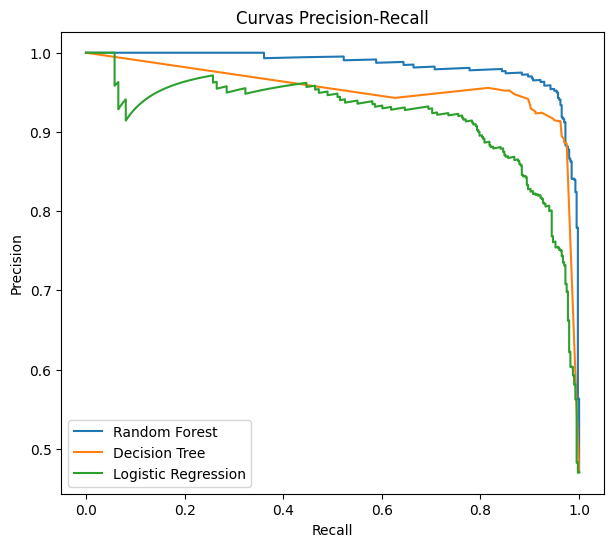

In [8]:
plt.figure(figsize=(7,6))

for nombre, modelo in modelos.items():
    if nombre == "Logistic Regression":
        X_eval, y_eval = X_test_std, y_test_std
    else:
        X_eval, y_eval = X_test_tree, y_test_tree
    
    if hasattr(modelo, "predict_proba"):
        y_proba = modelo.predict_proba(X_eval)[:,1]
        precision, recall, _ = precision_recall_curve(y_eval, y_proba)
        plt.plot(recall, precision, label=nombre)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas Precision-Recall")
plt.legend()
plt.savefig("../reports/14-curvas_precision_recall.jpg", dpi=300, bbox_inches="tight")
plt.show()

+ Random Forest domina también en la curva Precision-Recall, no solo en ROC. Esto refuerza su posición como el modelo más adecuado para la detección de morosidad.

+ Decision Tree es aceptable, pero inferior.

+ Logistic Regression se queda corta cuando el objetivo es capturar la mayor parte de morosos sin disparar falsos positivos.

## Importancia de las variables

In [9]:
feat_importances = pd.DataFrame({
    "Variable": X_test_tree.columns,
    "Importancia RF": rf_model.feature_importances_,
    "Importancia DT": dt_model.feature_importances_
})
display(feat_importances.sort_values("Importancia RF", ascending=False).head(10))

,Variable,Importancia RF,Importancia DT
19,Importe Cobrado,0.493093,0.644678
7,NUMERO DE CUOTAS,0.043896,0.026897
17,DIFERENCIA FECHA PRODUCCIÓN - 1ra CUOTA,0.041515,0.039335
2,IMPORTE INSCRIPCIÓN,0.037833,0.060600
1,FACTURACIÓN NETA,0.037307,0.043626
5,IMPORTE PENDIENTE PAGO,0.035660,0.030688
9,ASESOR,0.035214,0.014134
8,FORMA DE PAGO,0.033913,0.052432
6,MEDIO PAGO IMPORTE PENDIENTE,0.032175,0.009133
13,PAÍS DE RESIDENCIA,0.030553,0.012649


+ La variable “Importe Cobrado” domina con diferencia (≈ 49% en RF y 65% en DT).
+ El resto de variables tienen mucho menos peso (ninguna pasa del 5%).
+ Variables secundarias relevantes:
    + Nº de Cuotas
    + Diferencia Fecha Producción
    + Importe Inscripción
    + Facturación Neta

+ El resto aportan poco al modelo, pero en Random Forest ayudan más que en el árbol simple (distribuye la importancia entre más predictores).

# Conclusión

El análisis comparativo de los modelos entrenados muestra que:  

- **Random Forest optimizado** ofrece el mejor rendimiento global, con métricas muy altas tanto en **F1-score (0.95)** como en **ROC-AUC (0.99)**. Además, mantiene una excelente relación entre precisión y recall en la curva Precision-Recall, lo que lo convierte en la opción más robusta para la predicción de morosidad.  

- **Decision Tree optimizado**, aunque con un rendimiento ligeramente inferior (**F1-score 0.92, AUC 0.96**), aporta gran valor por su **interpretabilidad**, permitiendo explicar de manera clara las reglas que llevan a clasificar un cliente como moroso.  

- **Logistic Regression** funciona como un buen baseline (**F1-score 0.86, AUC 0.94**), pero queda claramente por debajo de los modelos basados en árboles en la detección de morosos.  

En cuanto a la importancia de las variables, tanto Random Forest como Decision Tree coinciden en que **“Importe Cobrado”** es el predictor más relevante, seguido a distancia por variables relacionadas con las **condiciones de pago** (número de cuotas, diferencia entre fechas de producción (venta) y de la primera cuota, etc).  

**Conclusión práctica:**  
Se recomienda utilizar **Random Forest en producción** por su capacidad de generalización y precisión, acompañado del **Decision Tree** como modelo de apoyo para la interpretación de las reglas y comunicación con áreas de negocio.  
